### requires python 3 and TSS conda environment (needed for parallelization)

### Motivation: 
TSS: Focused and dispersed. 
Within each TSS there are variations to where the start site occurs across different tissues. 
When calling our peaks, we choose the CHO peak if it occurs, otherwise pick the tissue with the maximum p-value.

One question that arises is when we call the TSS, how different are the read alignments when a) The TSS align b) The TSS are shifted between CHO and tissues and c) No CHO peak is seen, only tissues d) only CHO TSS

For each of these, how many TSS' are seen for each. How many tissues have a TSS when they all agree with CHO and when they are offset from CHO.

When they are offset versus aligned, what is the distribution of tags underneath (the density)


In the same vein, we want to make sure that the CHO GRO-Cap and CHO csRNA peaks are both showing similar buildup profiles, and that when plotting histograms, they don't just look good because the GRO-Cap is aligning on the GRO-cap peaks and csRNA aligning on csRNA peaks. Therefore, each should be done to the opposite calls.

In [1]:
## Parameters specific to where your folders are and your data
parameter_file = '../../parameters/params.yaml'
import yaml
import sys
import os
with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

#data_folder = doc['data_folder']
#tissues = doc['tissues'].split(',')
#sys.path.append(doc['pipeline_path'])
#anno_gff=doc['annotation']
#mRNA_peak_file = doc["mRNA_peak_file"]
#tss_annotation = doc['tss_annotation']
#data_folder = doc['data_folder']
tissues = doc['global']['TISSUES']
#sys.path.append(doc['pipeline_path'])
ref_fa = doc['GENOME_FA']
anno_gff=doc['ANNOTATION']
#mRNA_peak_file = doc["mRNA_peak_file"]

#tss_annotation = doc['tss_annotation']

import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from os.path import join
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
from tqdm import tqdm, tqdm_notebook

from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
#from Homer import *

homer_path =  "/data2/resources/software/homer/v4.11_10242019/bin/"
os.environ['PATH'] = f"{homer_path}:{os.environ['PATH']}"
!which homer

from matplotlib.lines import Line2D


from matplotlib import cm

from numpanpar import parallel_df as pardf
from tss.utils.Homer import read_bed_file
from tss.visualize.fig_utils import helper_save


/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  import sys


/data2/resources/software/homer/v4.11_10242019/bin//homer
params {'PREFIX': 'ncbi_pice_103', 'ROOT_DIR': '/data/isshamie/TSS/', 'DATA_DIR': '/data/isshamie/TSS/NCBI_PICR_103_Processed/', 'DATA_PROCESSED_DIR': '/data/isshamie/TSS/TSS/data/processed/', 'SUPPLEMENTAL_DIR': '/data/isshamie/TSS/Analysis/supplemental/', 'PIPELINE': '/data/isshamie/TSS/tss', 'GENOME_DIR': '/data/isshamie/genome', 'GENOME_FA': '/data/isshamie/genome/picr.fa', 'GENOME_GFF3': '/data/isshamie/genome/updated_final_sort.gff3', 'GENOME_GTF': '/data/isshamie/genome/updated_final_sort.gtf', 'TISSUES': 'BMDM1hKLA,BMDMwt,Brain,FemaleReproductive,Heart,Intestine,', 'META_FILE': '/data/isshamie/TSS/TSS/parameters/raw_metaSamples.tsv'}
fig_utils from mplh
/data2/resources/software/homer/v4.11_10242019/bin//


## Parameters and directories

In [2]:
os.chdir(doc["results"])

In [3]:
genome="GCF"
save_dir = join("compare_tissues_distance", "GCF")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

sample_peaks_dir = join(genome, "retrieve_peaks/")
merged_dir = join(genome,"merged")
tissues_dir = join(genome,"tissues_collapse")
eTSS_dir = join(genome,"eTSS")


### Load data

In [4]:
merged_df = pd.read_csv(join(merged_dir,"samples.merge"),sep="\t", index_col=0)
merged_df.head()

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Chr,Start,End,Strand,Stat,Parent files,Total subpeaks,MiscOrgans_START1_and_MiscOrgans_startinput1,Liver_START2_and_Liver_startinput1,Brain_GROCap1_and_Brain_GRO1,...,MiscOrgans_START2_and_MiscOrgans_startinput1,Spleen_START1_and_Spleen_startinput1,Lung_START2_and_Lung_startinput1,CHO_START1_and_CHO_startinput1,FemaleReproductive_START1_and_FemaleReproductive_startinput1,Kidney_START2_and_Kidney_startinput1,Kidney_GROCap1_and_Kidney_GRO1,CHO_GROCap1_and_CHO_GRO1,BMDMwt_GROCap1_and_BMDMwt_GRO1,Spleen_START2_and_Spleen_startinput1
ID,,,,,,,,,,,,,,,,,,,,,
0,NW_020822452.1,16590187,16590584,+,16.227333,MiscOrgans_START1_and_MiscOrgans_startinput1|B...,15,NW_020822452.1-1136,NaN,NW_020822452.1-1139,...,NaN,NaN,NaN,NW_020822452.1-450,NaN,NaN,NW_020822452.1-419,NW_020822452.1-145,NaN,NaN
1,NW_020822597.1,23595304,23595489,+,5.740000,MiscOrgans_START1_and_MiscOrgans_startinput1|B...,16,NW_020822597.1-387,NaN,NW_020822597.1-324,...,NW_020822597.1-103,NW_020822597.1-248,NW_020822597.1-10,NaN,NW_020822597.1-101,NaN,NaN,NaN,NaN,NW_020822597.1-126
2,NW_020822680.1,728607,728829,+,7.579579,MiscOrgans_START1_and_MiscOrgans_startinput1|B...,19,NW_020822680.1-92,NaN,NW_020822680.1-114,...,NaN,NaN,NaN,NW_020822680.1-37,NW_020822680.1-56,NaN,NW_020822680.1-67,NW_020822680.1-19,NW_020822680.1-44,NW_020822680.1-72
3,NW_020822602.1,10883074,10883337,+,3.992000,MiscOrgans_START1_and_MiscOrgans_startinput1|B...,20,NW_020822602.1-204,NaN,NaN,...,NW_020822602.1-254,NW_020822602.1-122,NaN,NW_020822602.1-226,NaN,NaN,NaN,NW_020822602.1-303,NW_020822602.1-594,NW_020822602.1-266
4,NW_020822601.1,37427816,37427999,+,129.031738,MiscOrgans_START1_and_MiscOrgans_startinput1|B...,23,NW_020822601.1-18,NaN,NW_020822601.1-1445,...,NW_020822601.1-52,NW_020822601.1-123,NaN,NW_020822601.1-41,NaN,NaN,NW_020822601.1-1949,NW_020822601.1-992,NW_020822601.1-2287,NW_020822601.1-12


In [5]:
meta_df = pd.read_csv(join(eTSS_dir,"TSS.exp.meta.tsv"), sep="\t", index_col=0)
meta_df["ID"] = meta_df["ID"].fillna(-1).astype(int)
bed_df = read_bed_file(join(eTSS_dir,"TSS.exp.bed"))
meta_df.head()


,Tissues,cs,CHO ATAC Region,ID,Gene,Gene ID,Transcript,Is Experimental
p1@Bmp4_XM_027386529.1,"Brain,Spleen,Lung,FemaleReproductive,Kidney,Mi...",0b11,NaN,348823,Bmp4,NaN,XM_027386529.1,1.0
p2@Bmp4_XM_027386529.1,"Brain,Spleen,Lung,FemaleReproductive,Kidney,Mi...",0b00,NaN,90264,Bmp4,NaN,XM_027386529.1,1.0
p3@Bmp4_XM_027386529.1,"Brain,Spleen,Lung,FemaleReproductive,Kidney,Mi...",0b00,NaN,181215,Bmp4,NaN,XM_027386529.1,1.0
p1@Bmp4_XM_027386528.1,"BMDMwt,Brain,Spleen,Lung,Pancreas,FemaleReprod...",0b11,NaN,308710,Bmp4,NaN,XM_027386528.1,1.0
p1@Cdkn3_XM_027386531.1,"Brain,Spleen,Lung,CHO,FemaleReproductive,MiscO...",0b11,NaN,237253,Cdkn3,NaN,XM_027386531.1,1.0


## Construct peak-by-location data

In [6]:
sample_files = glob.glob(os.path.join(sample_peaks_dir, "sample_*"))
columns = list(map(lambda x: x.split("sample_")[1].split(".tsv")[0],sample_files))
files_dict = {c:sample_files[ind] for ind, c in enumerate(columns)}
peak_by_location = pd.DataFrame(index=meta_df["ID"],columns=columns)
peak_by_location.head()

,Kidney_START2_and_Kidney_startinput1,Lung_START2_and_Lung_startinput1,Liver_START2_and_Liver_startinput1,Brain_START1_and_Brain_startinput2,Spleen_START2_and_Spleen_startinput1,Liver_START1_and_Liver_startinput1,Brain_START3_and_Brain_startinput2,BMDM1hKLA_GROCap1_and_BMDM1hKLA_GRO1,Lung_START1_and_Lung_startinput1,CHO_GROCap2_and_CHO_GRO2,...,Heart_START1_and_Heart_startinput1,MiscOrgans_START1_and_MiscOrgans_startinput1,Brain_START2_and_Brain_startinput1,CHO_GROCap2_and_CHO_GRO1,Pancreas_START1_and_Pancreas_startinput1,CHO_START1_and_CHO_startinput1,Liver_GROCap1_and_Liver_GRO1,CHO_GROCap1_and_CHO_GRO2,Heart_START2_and_Heart_startinput1,Pancreas_START2_and_Pancreas_startinput1
ID,,,,,,,,,,,,,,,,,,,,,
348823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### To start, use all samples in columns (can average over tissues later)

A. Create a dictionary where each sample is a key and their dataframe of peaks is the value  
B. Loop through the meta_df IDs.   
    For each ID:  
    Determine which samples had the ID (use merged to determine where there is no null)  
    Loop through each sample that had the peak:  
        Get the peak from their sample_{sample} file, and get their location and fill it in. 
    

### Create sample dictionary

In [7]:
sample_dict = dict()
for ind, f in enumerate(sample_files):
    print(f)
    print(columns[ind])
    name = columns[ind]
    sample_dict[name] = pd.read_csv(f, sep="\t")

GCF/retrieve_peaks/sample_Kidney_START2_and_Kidney_startinput1.tsv
Kidney_START2_and_Kidney_startinput1
GCF/retrieve_peaks/sample_Lung_START2_and_Lung_startinput1.tsv
Lung_START2_and_Lung_startinput1
GCF/retrieve_peaks/sample_Liver_START2_and_Liver_startinput1.tsv
Liver_START2_and_Liver_startinput1
GCF/retrieve_peaks/sample_Brain_START1_and_Brain_startinput2.tsv
Brain_START1_and_Brain_startinput2
GCF/retrieve_peaks/sample_Spleen_START2_and_Spleen_startinput1.tsv
Spleen_START2_and_Spleen_startinput1
GCF/retrieve_peaks/sample_Liver_START1_and_Liver_startinput1.tsv
Liver_START1_and_Liver_startinput1
GCF/retrieve_peaks/sample_Brain_START3_and_Brain_startinput2.tsv
Brain_START3_and_Brain_startinput2
GCF/retrieve_peaks/sample_BMDM1hKLA_GROCap1_and_BMDM1hKLA_GRO1.tsv
BMDM1hKLA_GROCap1_and_BMDM1hKLA_GRO1
GCF/retrieve_peaks/sample_Lung_START1_and_Lung_startinput1.tsv
Lung_START1_and_Lung_startinput1
GCF/retrieve_peaks/sample_CHO_GROCap2_and_CHO_GRO2.tsv
CHO_GROCap2_and_CHO_GRO2
GCF/retrieve_pea

In [8]:
def par_peak_by_location(df, files_dict):
    # Dataframe will be sample-by-peak instead of peak-by-sample to make the parallelization work
    for name in df.index.values:
        #name = columns[ind]
        f = files_dict[name]
        curr_sample = pd.read_csv(f, sep="\t", index_col=0)
        curr_merge = pd.read_csv(f.replace("sample","merged"), sep="\t", index_col=0)
        #curr_merge = curr_merge.loc[:,curr_merge.columns.str.contains("f04_peaks/")]        
        #curr_merge.columns = list(map(lambda x: x.split("f04_peaks/")[1], curr_merge.columns.values))
        curr_merge.columns = list(map(lambda x: basename(x), curr_merge.columns.values))
        # Remove the comma, indicating multiple peaks, which doesnt happen often
        curr_merge = curr_merge.loc[~(curr_merge[name].str.contains(",")), name] #Take only the column of the sample

        for ind2, val in tqdm(curr_merge.iteritems()):
            df.loc[name,ind2] = np.floor((curr_sample.loc[val, "Start"] + curr_sample.loc[val, "End"])/2)  
    return df

In [9]:
peak_by_location = pardf(peak_by_location.transpose(), par_peak_by_location, func_args=(files_dict,), num_processes=24).transpose()
peak_by_location = peak_by_location.sort_index()

4989it [00:07, 677.38it/s]
8304it [00:11, 700.96it/s]
6995it [00:12, 555.87it/s]
8310it [00:14, 561.96it/s]]
8615it [00:15, 573.89it/s]]
8624it [00:15, 572.47it/s]
10725it [00:15, 691.30it/s]
12198it [00:16, 718.03it/s]
9854it [00:16, 583.73it/s]]
10112it [00:17, 579.15it/s]
10668it [00:18, 589.31it/s]
10575it [00:18, 571.06it/s]
11369it [00:18, 304.91it/s]
10742it [00:19, 546.58it/s]
11322it [00:19, 569.12it/s]
12372it [00:21, 576.26it/s]
12104it [00:21, 551.96it/s]
12622it [00:22, 551.53it/s]
12381it [00:23, 536.74it/s]
6298it [00:08, 757.92it/s]]
12294it [00:16, 745.28it/s]
11543it [00:24, 463.56it/s]
13015it [00:24, 520.70it/s]
13650it [00:25, 545.01it/s]
13767it [00:25, 535.70it/s]
13057it [00:27, 481.49it/s]
10424it [00:15, 668.44it/s]
9332it [00:12, 729.77it/s]]
9898it [00:12, 800.59it/s]]
9824it [00:12, 809.46it/s]]
9682it [00:11, 834.87it/s]]
8603it [00:13, 652.38it/s]]
11989it [00:14, 815.30it/s]
13204it [00:22, 590.04it/s]
12455it [00:20, 605.72it/s]


In [10]:
peak_by_location

,Kidney_START2_and_Kidney_startinput1,Lung_START2_and_Lung_startinput1,Liver_START2_and_Liver_startinput1,Brain_START1_and_Brain_startinput2,Spleen_START2_and_Spleen_startinput1,Liver_START1_and_Liver_startinput1,Brain_START3_and_Brain_startinput2,BMDM1hKLA_GROCap1_and_BMDM1hKLA_GRO1,Lung_START1_and_Lung_startinput1,CHO_GROCap2_and_CHO_GRO2,...,Heart_START1_and_Heart_startinput1,MiscOrgans_START1_and_MiscOrgans_startinput1,Brain_START2_and_Brain_startinput1,CHO_GROCap2_and_CHO_GRO1,Pancreas_START1_and_Pancreas_startinput1,CHO_START1_and_CHO_startinput1,Liver_GROCap1_and_Liver_GRO1,CHO_GROCap1_and_CHO_GRO2,Heart_START2_and_Heart_startinput1,Pancreas_START2_and_Pancreas_startinput1
ID,,,,,,,,,,,,,,,,,,,,,
4,NaN,NaN,NaN,3.74279e+07,3.74279e+07,3.74279e+07,NaN,NaN,3.74279e+07,NaN,...,3.74279e+07,3.74279e+07,3.74279e+07,NaN,NaN,3.74279e+07,3.74279e+07,3.74279e+07,NaN,3.74279e+07
5,NaN,NaN,NaN,2.23185e+06,2.23185e+06,2.23185e+06,2.23179e+06,NaN,2.23185e+06,NaN,...,2.23179e+06,2.23185e+06,2.23185e+06,NaN,2.23179e+06,NaN,2.2318e+06,NaN,NaN,2.23185e+06
6,6.31425e+06,NaN,6.31425e+06,6.31425e+06,6.31417e+06,6.31426e+06,NaN,NaN,6.31425e+06,NaN,...,6.31418e+06,6.31426e+06,6.31416e+06,6.31417e+06,6.31418e+06,6.31417e+06,6.31426e+06,NaN,6.31426e+06,6.31416e+06
8,NaN,461893,NaN,461843,461843,461843,NaN,461615,461843,NaN,...,461915,461843,461843,NaN,461805,461848,461738,NaN,461802,461747
12,NaN,1.11742e+06,1.11742e+06,NaN,NaN,1.11736e+06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.1174e+06,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540101,NaN,NaN,NaN,694137,NaN,NaN,NaN,NaN,694195,NaN,...,NaN,NaN,694147,NaN,NaN,NaN,NaN,NaN,NaN,NaN
540110,NaN,NaN,4.6711e+06,4.67112e+06,4.6711e+06,NaN,4.6711e+06,4.67115e+06,4.67112e+06,NaN,...,NaN,4.6711e+06,4.67112e+06,4.6711e+06,NaN,4.6711e+06,NaN,NaN,NaN,NaN
540113,NaN,NaN,NaN,5.40738e+07,5.40738e+07,NaN,5.40737e+07,NaN,5.40737e+07,NaN,...,5.40738e+07,NaN,5.40738e+07,5.40739e+07,NaN,5.40738e+07,NaN,NaN,5.40738e+07,5.40737e+07


In [11]:
peak_by_location.to_csv(os.path.join(save_dir,"peak_by_location.tsv"), sep="\t")

In [12]:
def median_distance(peaks_df, peak_by_location,is_start=True,method='median'):
    if is_start:
        if method == 'median':
            peaks_df['median_distance'] = -1
            for ind, val in peak_by_location.iterrows():
#                 print(ind)
#                 print(peaks_df.loc[ind,"Start"] - val)
#                 print(peaks_df.loc[ind,"Start"])
                #peaks_df.at[ind, 'median_distance'] = np.nanmedian(np.abs(val["Start"] - peak_by_location.loc[ind]))
                #print('median',np.nanmedian(np.abs(peaks_df.loc[ind,"Start"] - val)))
                #print((np.abs(peaks_df.loc[ind,"Start"] - val)).median())
                peaks_df.at[ind, 'median_distance'] = (np.abs(peaks_df.loc[ind,"Start"] - val)).median()
        elif method=='max':
            peaks_df['max_distance'] = -1
            for ind, val in peak_by_location.iterrows():
                #peaks_df.at[ind, 'max_distance'] = np.nanmax(np.abs(val["Start"] - peak_by_location.loc[ind]))
                peaks_df.at[ind, 'max_distance'] = (np.abs(peaks_df.loc[ind,"Start"] - val)).max()
    else:
        print("TO DO. Peak might need to be centered")
        return
    return peaks_df


def calculate_distance(tissues_expr, peaks_df, peak_by_location):
    tss_dist_df = pd.DataFrame(columns= ["Median", "Max", "Number of Tissues", "Average TSS"])
    tss_dist_df = peaks_df.loc[peak_by_location.index]
    tissues_expr = tissues_expr.loc[peak_by_location.index]
    
    tss_dist_df = median_distance(tss_dist_df,peak_by_location,True,'median')
    tss_dist_df = median_distance(tss_dist_df,peak_by_location,True,'max')
    tss_dist_df["Number of Tissues"] = (tissues_expr>0).sum(axis=1)
    tss_dist_df["Average Expression"] = tissues_expr.apply(lambda x: x[x>0].mean(),axis=1)
    #tss_dist_df = pardf(peaks_df,median_distance, func_args=(peak_by_location,True,'median'), num_processes=24)
    #tss_dist_df = pardf(peaks_df,median_distance, func_args=(peak_by_location, True,'max'), num_processes=24)
    return tss_dist_df

In [13]:
#peaks_df = join(merged_dir, "samples.merge")
tissues_expr = pd.read_csv(join(tissues_dir,"tissues.merge.peaksexpression"),sep="\t", index_col=0)
peaks_df = pd.read_csv(join(merged_dir, 'peaks_with_tss_distances_size1.peak'),sep="\t", index_col=0)

tss_dist_df = calculate_distance(tissues_expr, peaks_df, peak_by_location)
tss_dist_df


,Chr,Start,End,Strand,Stat,Annotation,Nearest TSS,Distance to TSS,isSameStrand,Nearest gene,median_distance,max_distance,Number of Tissues,Average Expression
ID,,,,,,,,,,,,,,
4,NW_020822601.1,37427907,37427907,+,129.031738,promoter-TSS (ID=exon-XM_027421990.1-1;Parent=...,XM_027421990.1,-11.0,True,Shf,17,17,12,76.641437
5,NW_020822619.1,2231822,2231822,-,16.203333,promoter-TSS (ID=exon-XM_027428527.1-1;Parent=...,XM_027428527.1,-296.0,True,LOC100764847,24,29,11,13.621991
6,NW_020822577.1,6314212,6314212,+,11.444000,promoter-TSS (ID=exon-XM_027418757.1-1;Parent=...,XM_027418757.1,47.0,True,Marc1,42,52,12,8.899845
8,NW_020822435.1,461807,461807,-,6.744815,promoter-TSS (ID=exon-XM_027395141.1-1;Parent=...,XM_027395157.1,-85.0,True,Dnajb4,38,193,13,5.320458
12,NW_020822644.1,1117393,1117393,-,3.882334,promoter-TSS (ID=exon-XM_027430636.1-1;Parent=...,XM_027430636.1,-1.0,True,LOC113830776,22,31,4,2.016750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540101,NW_020822703.1,694166,694166,+,4.267500,promoter-TSS (ID=exon-XM_027433629.1-1;Parent=...,XM_027433629.1,15.0,True,Lrch2,19,29,4,2.266131
540110,NW_020822610.1,4671122,4671122,+,3.941875,promoter-TSS (ID=exon-XM_027425193.1-1;Parent=...,XM_027425193.1,-273.0,True,Ubtd2,26,27,9,2.108069
540113,NW_020822415.1,54073794,54073794,+,5.232727,promoter-TSS (ID=exon-XM_027392614.1-1;Parent=...,XM_027392616.1,-21.0,True,Ikbip,36,78,10,3.415310


## Plot based on number of tissues

In [14]:
f,ax = plt.subplots()

#tss_dist_df[~(tss_dist_df["Number of Tissues"]==0)] 

#tss_dist_df = tss_dist_df[~(tss_dist_df["Number of Tissues"]==1)] 
sns.boxplot(y="median_distance",x="Number of Tissues", data=(tss_dist_df),color="blue", ax = ax)
plt.title("Distance of tissue peaks to eTSS peak")

helper_save(join(save_dir, "median_distance_from_eTSS"))

viridis = cm.get_cmap('Blues', 24)
stats_by_tissues = tss_dist_df.groupby("Number of Tissues").mean()["Stat"]
stats_norm = stats_by_tissues/tss_dist_df.groupby("Number of Tissues").mean()["Stat"].max()
max_stats = stats_by_tissues.max()

f,ax = plt.subplots(1)
sns.boxplot(y="max_distance",x="Number of Tissues", data=(tss_dist_df), ax=ax,color='blue')
plt.title("Distance of tissue peaks to eTSS peak")
helper_save(join(save_dir, "max_distance_from_eTSS"))

In [15]:
f = plt.figure()

sns.violinplot(y="median_distance",x="Number of Tissues", data=tss_dist_df)
f = plt.figure()
sns.violinplot(y="max_distance",x="Number of Tissues", data=tss_dist_df)

In [16]:
f = plt.figure()

tss_dist_df["log2 Median"] = np.log2(tss_dist_df["median_distance"]+1)
tss_dist_df["log2 Max"] = np.log2(tss_dist_df["max_distance"]+1)

#tss_dist_df[~(tss_dist_df["Number of Tissues"]==0)] 

tss_dist_df = tss_dist_df[~(tss_dist_df["Number of Tissues"]==1)] 

sns.violinplot(y="log2 Median",x="Number of Tissues", data=(tss_dist_df))
plt.yscale('log')

f = plt.figure()
sns.violinplot(y="log2 Max",x="Number of Tissues", data=(tss_dist_df))
plt.yscale('log')


In [17]:
f,ax = plt.subplots()

tss_dist_df["log2 Median"] = np.log2(tss_dist_df["median_distance"]+1)
tss_dist_df["log2 Max"] = np.log2(tss_dist_df["max_distance"]+1)

#tss_dist_df[~(tss_dist_df["Number of Tissues"]==0)] 

tss_dist_df = tss_dist_df[~(tss_dist_df["Number of Tissues"]==1)] 
sns.boxplot(y="log2 Median",x="Number of Tissues", data=(tss_dist_df),color="blue", ax = ax)
plt.title("Distance of tissue peaks to eTSS peak")
helper_save(join(save_dir, "log2plus1_median_distance_from_eTSS"))

viridis = cm.get_cmap('Blues', 24)
stats_by_tissues = tss_dist_df.groupby("Number of Tissues").mean()["Stat"]
stats_norm = stats_by_tissues/tss_dist_df.groupby("Number of Tissues").mean()["Stat"].max()
max_stats = stats_by_tissues.max()

f,ax = plt.subplots(1)
sns.boxplot(y="log2 Max",x="Number of Tissues", data=(tss_dist_df), ax=ax,color='blue')
plt.title("Distance of tissue peaks to eTSS peak")
helper_save(join(save_dir, "log2plus1_max_distance_from_eTSS"))

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [18]:
f = plt.figure()
#tss_dist_df.loc[tss_dist_df["max_distance"]>300,"max_distance"] = 300

plt.hist(np.clip(tss_dist_df["median_distance"],0,300),bins=25)
plt.xlabel("Median distance of tissue peaks to eTSS peak")
helper_save(join(save_dir, "distribution_median_distance_from_eTSS"))

f = plt.figure()
plt.hist(np.clip(tss_dist_df["max_distance"],0,300),bins=25)
plt.xlabel("Maximum distance of tissue peaks to eTSS peak")
helper_save(join(save_dir, "distribution_max_distance_from_eTSS"))

In [26]:
import math

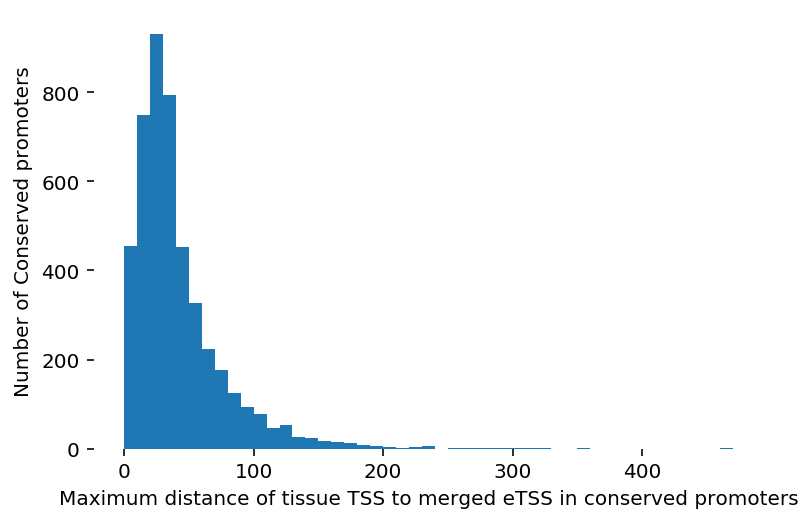

In [31]:
%matplotlib inline

housekeeping = tss_dist_df[tss_dist_df["Number of Tissues"] == tss_dist_df["Number of Tissues"].max()]
f = plt.figure()

w = 10
n = math.ceil((housekeeping["max_distance"].max() - housekeeping["max_distance"].min())/w)

plt.hist(housekeeping["max_distance"],bins=n)
plt.xlabel("Maximum distance of tissue TSS to merged eTSS in conserved promoters")
plt.ylabel("Number of Conserved promoters")
helper_save(join(save_dir, "distribution_max_distance_conserved"))

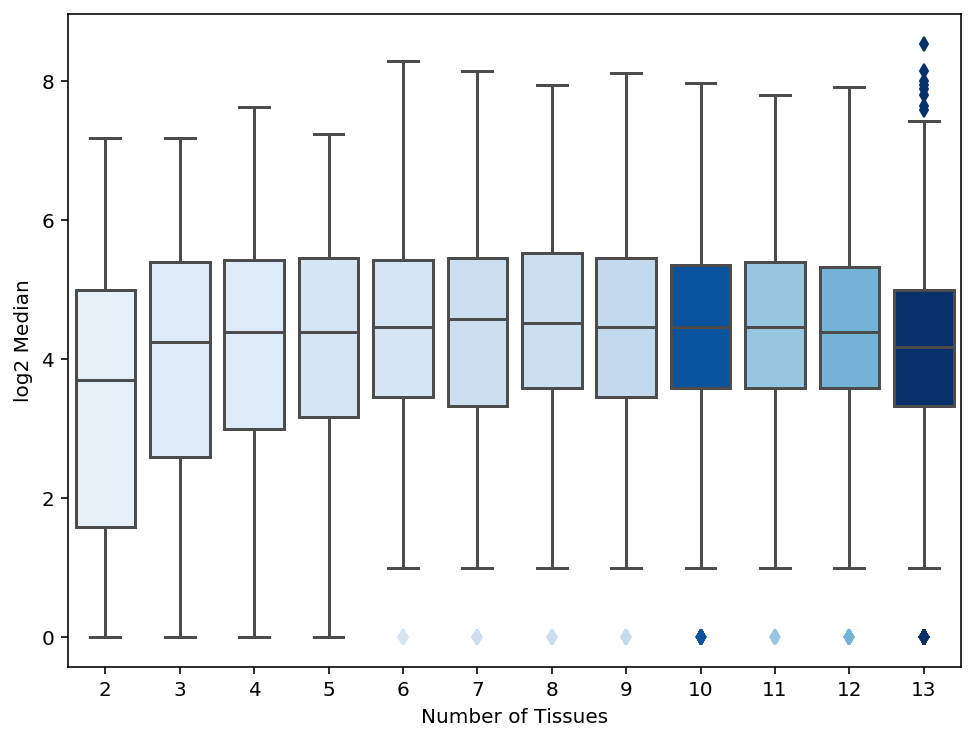

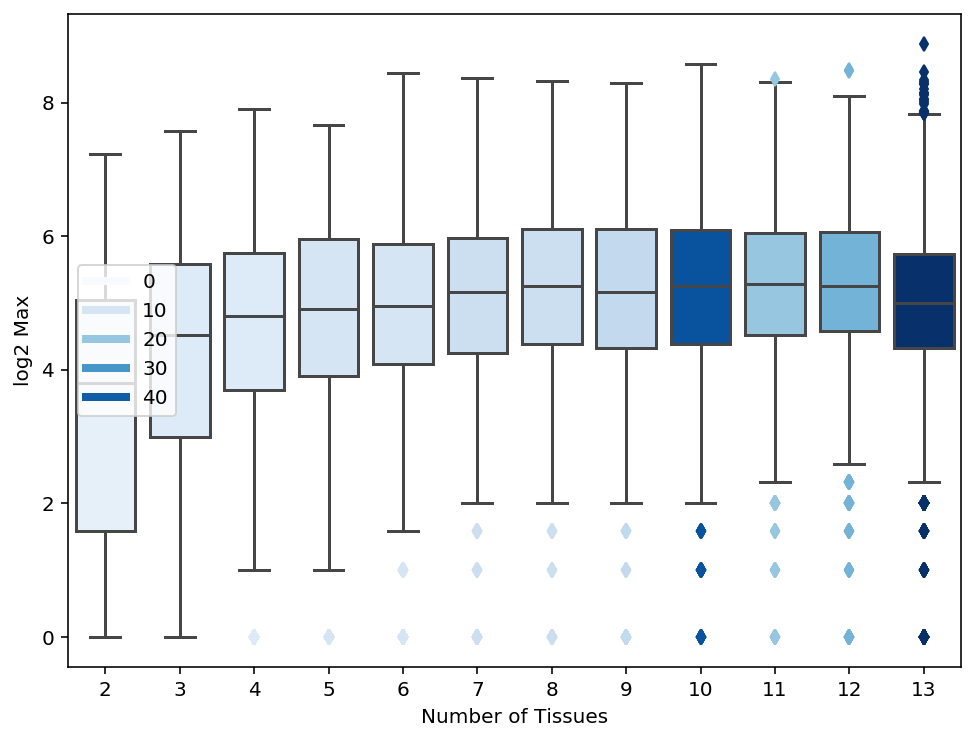

In [20]:
f,ax = plt.subplots()

tss_dist_df["log2 Median"] = np.log2(tss_dist_df["median_distance"]+1)
tss_dist_df["log2 Max"] = np.log2(tss_dist_df["max_distance"]+1)

#tss_dist_df[~(tss_dist_df["Number of Tissues"]==0)] 

tss_dist_df = tss_dist_df[~(tss_dist_df["Number of Tissues"]==1)] 
sns.boxplot(y="log2 Median",x="Number of Tissues", data=(tss_dist_df),color="blue", ax = ax)

viridis = cm.get_cmap('Blues', 24)
stats_by_tissues = tss_dist_df.groupby("Number of Tissues").mean()["Stat"]
stats_norm = stats_by_tissues/tss_dist_df.groupby("Number of Tissues").mean()["Stat"].max()
max_stats = stats_by_tissues.max()

color_vals = list(map(lambda x: viridis(x), stats_norm ))
for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = color_vals[i] #artist.get_facecolor()
    artist.set_facecolor(col)
    #artist.set_edgecolor(col)
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        #line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

f,ax = plt.subplots(1)
sns.boxplot(y="log2 Max",x="Number of Tissues", data=(tss_dist_df), ax=ax)

for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = color_vals[i] #artist.get_facecolor()
    artist.set_facecolor(col)
    #artist.set_edgecolor(col)
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        #line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

# Also fix the legend
#sns.palplot(list(map(lambda x: viridis(x),np.arange(0,1,1/12))))


ax.legend(map(lambda x: Line2D([0],[0],color=x,lw=4), list(map(lambda x: viridis(x),np.arange(0,1,1/5)))),
              np.arange(0,max_stats,max_stats/5, dtype=int), loc="best")
# for legpatch in ax.get_legend().get_patches():
#     col = legpatch.get_facecolor()
#     legpatch.set_edgecolor(col)
#     legpatch.set_facecolor('None')